# Random Forest Regressor

In [1]:
# Loading modules required for data manipulation an EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading modules required for modelling
from sklearn.ensemble import RandomForestRegressor      # To access the Random forest regressor
from sklearn.model_selection import KFold               # To create training/testing sets
from sklearn.model_selection import GridSearchCV        # To creat a tuning grid for hyperparameters
from sklearn.decomposition import PCA                   # Feature selection tool
from sklearn.pipeline import make_pipeline              # Lets us build a pipeline

# Loading modules to assess error
from sklearn.metrics import mean_squared_error          # To measure the mean of residual errors 
from sklearn.metrics import r2_score                    # To measure the accuracy of the fit

# loading modules to assess model
from sklearn.model_selection import cross_val_score     # To determine the model's cross validation accuracy scores
from sklearn.metrics import accuracy_score              # To determine the model's accuracy
from sklearn.dummy import DummyRegressor                # To create a regressor baseline

# Loading modules to plot confusion matrix
import matplotlib.pyplot as plt                         # This one
import seaborn as sns                                   # ... and this one are used to create figure objects
from sklearn.metrics import confusion_matrix            # To create confusion matrix
%matplotlib inline

In [2]:
# Importing Data
features = pd.read_csv('X.csv')
target = pd.read_csv('y.csv')

# Random forests are good at finding the latent information from features

## Data Segregation
Splitting the data into 5 folds (80/20 split) and eabling reproducibility

In [38]:
# Creating numpy arrays of data to get k-folds 
X = np.array(features)
y = np.array(target)
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)
print('Number of splits: ', kf.get_n_splits(X))

# Assigning the training and testing sets data based on the splits
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Returning array back to Dataframe
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

# Assessing sets
print('Dataset shapes: ', features.shape, "and ", target.shape)
print('Training set shape: ', X_train.shape, "and", y_train.shape)
print('Testing set shape: ', X_test.shape, "and ", y_test.shape)

Number of splits:  5
Dataset shapes:  (822, 30) and  (822, 1)
Training set shape:  (658, 30) and (658, 1)
Testing set shape:  (164, 30) and  (164, 1)


#### Creating Baseline

In [39]:
# Creating naive baseline to compare with
baseline = np.mean(y_train.iloc[:, 0].to_numpy())
y_baseline = np.repeat(baseline, len(y_test.iloc[:, 0].to_numpy()))
naive_MSE = mean_squared_error(y_test, y_baseline)
naive_RMSE = np.sqrt(naive_MSE)
naive_rr = r2_score(y_test, y_baseline)

# Creating a DummyRegressor baseline
dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
y_predict_dummy_mean = dummy_mean.predict(X_test)
dummy_MSE = mean_squared_error(y_test, y_predict_dummy_mean)
dummy_RMSE = np.sqrt(dummy_MSE)
dummy_rr = r2_score(y_test, y_predict_dummy_mean)

## Training Model
Deviating from the default slightly by setting the number of trees to 200 and the maximum depth to 4. Reproducibility has also been ensured.

In [44]:
# Creating model
model_rf = RandomForestRegressor(n_estimators = 200, max_depth = 4, random_state = 42)
print("Before optimization with tuning: ", model_rf.get_params())

Before optimization with tuning:  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 4, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [45]:
# Training the model on training data
model_rf.fit(X_train, y_train.iloc[:, 0].to_numpy())
model_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 4,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [46]:
# Deteriming cross fold validation scores
    # Creating a function to calculate the average
def average(lst):
    return sum(lst) / len(lst)

score_untuned_rf = cross_val_score(model_rf, features, target.iloc[:, 0].to_numpy(), cv = 5)
print("Cross Validation scores (untuned): ", score_untuned_rf, "\nCV score = ", average(score_untuned_rf)) 

Cross Validation scores (untuned):  [0.90770677 0.22289526 0.81462055 0.86609359 0.85101234] 
CV score =  0.7324657025457155


In [47]:
# Making prediction and assessing
preds_train_untuned_rf = model_rf.predict(X_train)
preds_test_untuned_rf = model_rf.predict(X_test)

# Measuring MSE
MSE_training_preds = mean_squared_error(y_train, preds_train_untuned_rf)
MSE_testing_preds = mean_squared_error(y_test, preds_test_untuned_rf)

# Measuring RMSE
RMSE_training_preds = np.sqrt(MSE_training_preds)
RMSE_testing_preds = np.sqrt(MSE_testing_preds)

# Measuring R-squared
rsq_training_preds = r2_score(y_train, preds_train_untuned_rf)
rsq_testing_preds = r2_score(y_test, preds_test_untuned_rf)


scores = {'Test':  ['Naive Baseline', 'Dummy Baseline', 'Random Forest on Training', 'Random Forest on Testing'],
          'MSE': [round(naive_MSE, 5), round(dummy_MSE, 5), round(MSE_training_preds, 5), round(MSE_testing_preds, 5)],
          'RMSE': [round(naive_RMSE, 5), round(dummy_RMSE, 5), round(RMSE_training_preds, 5), round(RMSE_testing_preds, 5)],
          'R-squared': [round(naive_rr, 5), round(dummy_rr, 5), round(rsq_training_preds, 5), round(rsq_testing_preds, 5)]
        }

scores_df = pd.DataFrame(scores)
print("\nHere are some performace metrics associated with the mean baseline and the untuned model:")
scores_df.head()


Here are some performace metrics associated with the mean baseline and the untuned model:


,Test,MSE,RMSE,R-squared
0,Naive Baseline,0.02372,0.15403,-0.00029
1,Dummy Baseline,0.02372,0.15403,-0.00029
2,Random Forest on Training,0.00196,0.04425,0.91784
3,Random Forest on Testing,0.00340,0.05829,0.85674


## Model Tuning
The above model may have some overfitting issues, but after many hours no solution has been obtained. More data required, but not the best model choice anyway. (Good thing I decided to try learn an extra!).

In [51]:
# Creatinga grid of hyperparameters
grid_rf = {'n_estimators': [100, 200, 500],
           'max_depth': [4, 7, 10], # 11 caused overfitting issues
           'max_features': [1, 5, 10],
           }

# Tuning hyperparameters
tuned_rf = GridSearchCV(model_rf, grid_rf, cv = 5)

# Building tuned model on training data
tuned_rf.fit(X_train, y_train.iloc[:, 0].to_numpy()) 
print(tuned_rf.best_params_)

# Deteriming cross fold validation scores
score_tuned_rf = cross_val_score(tuned_rf, features, target.iloc[:, 0].to_numpy(), cv = 5)
print("Cross Validation scores (tuned): ", score_tuned_rf, "\nCV score = ", average(score_tuned_rf)) 

{'max_depth': 10, 'max_features': 10, 'n_estimators': 500}
Cross Validation scores (tuned):  [0.83310556 0.14649046 0.85909778 0.88824993 0.82016326] 
CV score =  0.7094213967310998


In [52]:
# Making prediction and assessing tuned model
preds_train_tuned_rf = tuned_rf.predict(X_train)
preds_test_tuned_rf = tuned_rf.predict(X_test)

# Measuring MSE
MSE_training_preds = mean_squared_error(y_train, preds_train_tuned_rf)
MSE_testing_preds = mean_squared_error(y_test, preds_test_tuned_rf)

# Measuring RMSE
RMSE_training_preds = np.sqrt(MSE_training_preds)
RMSE_testing_preds = np.sqrt(MSE_testing_preds)

# Measuring R-squared
rsq_training_preds = r2_score(y_train, preds_train_tuned_rf)
rsq_testing_preds = r2_score(y_test, preds_test_tuned_rf)


scores = {'Test':  ['Naive Baseline', 'Dummy Baseline', 'Random Forest on Training', 'Random Forest on Testing'],
          'MSE': [round(naive_MSE, 5), round(dummy_MSE, 5), round(MSE_training_preds, 5), round(MSE_testing_preds, 5)],
          'RMSE': [round(naive_RMSE, 5), round(dummy_RMSE, 5), round(RMSE_training_preds, 5), round(RMSE_testing_preds, 5)],
          'R-squared': [round(naive_rr, 5), round(dummy_rr, 5), round(rsq_training_preds, 5), round(rsq_testing_preds, 5)]
        }

scores_df = pd.DataFrame(scores)
print("\nHere are some performace metrics associated with the mean baseline and the tuned model:")
scores_df.head()


Here are some performace metrics associated with the mean baseline and the tuned model:


,Test,MSE,RMSE,R-squared
0,Naive Baseline,0.02372,0.15403,-0.00029
1,Dummy Baseline,0.02372,0.15403,-0.00029
2,Random Forest on Training,0.00049,0.02221,0.97930
3,Random Forest on Testing,0.00261,0.05105,0.89013


In [57]:
# Creating model with feature selection (PCA)
pca = PCA(whiten = True,                                # Using uncorrelated components
          random_state = 42)                            # Setting a seed

model_pca_rf = make_pipeline(pca, tuned_rf)

# Tuning model
grid_rf = {'pca__n_components': [#1, 5, 10, 15, 
                                20, 25, 27, 28, 29, 30],
           }

tuned_rf_pca = GridSearchCV(model_pca_rf, grid_rf, cv = 5)

# Trainning model on trainning data
tuned_rf_pca.fit(X_train, y_train.iloc[:, 0].to_numpy())
print(tuned_rf_pca.best_params_)

# Testing model on training and testing set
pca_train_untuned_prediction = tuned_rf_pca.predict(X_train)
pca_test_untuned_prediction = tuned_rf_pca.predict(X_test)

# Measuring MSE 
RMSE_training_preds_pca = mean_squared_error(y_train, pca_train_untuned_prediction)
RMSE_testing_preds_pca = mean_squared_error(y_test, pca_test_untuned_prediction)

# Measuring RMSE 
RMSE_training_preds_pca = np.sqrt(RMSE_training_preds_pca)
RMSE_testing_preds_pca = np.sqrt(RMSE_testing_preds_pca)

# Measuring R-squared
rsq_training_preds = r2_score(y_train, pca_train_untuned_prediction)
rsq_testing_preds = r2_score(y_test, pca_test_untuned_prediction)


scores = {'Test':  ['Naive Baseline', 'Dummy Baseline', 'Random Forest on Training', 'Random Forest on Testing'],
          'MSE': [round(naive_MSE, 5), round(dummy_MSE, 5), round(MSE_training_preds, 5), round(MSE_testing_preds, 5)],
          'RMSE': [round(naive_RMSE, 5), round(dummy_RMSE, 5), round(RMSE_training_preds, 5), round(RMSE_testing_preds, 5)],
          'R-squared': [round(naive_rr, 5), round(dummy_rr, 5), round(rsq_training_preds, 5), round(rsq_testing_preds, 5)]
        }

scores_df = pd.DataFrame(scores)
print("\nHere are some performace metrics associated with the mean baseline and the PCA/tuned model:")
scores_df.head()

{'pca__n_components': 29}

Here are some performace metrics associated with the mean baseline and the PCA/tuned model:


,Test,MSE,RMSE,R-squared
0,Naive Baseline,0.02372,0.15403,-0.00029
1,Dummy Baseline,0.02372,0.15403,-0.00029
2,Random Forest on Training,0.00049,0.02221,0.94063
3,Random Forest on Testing,0.00261,0.05105,0.71865


Text(0, 0.5, 'Fitted values')

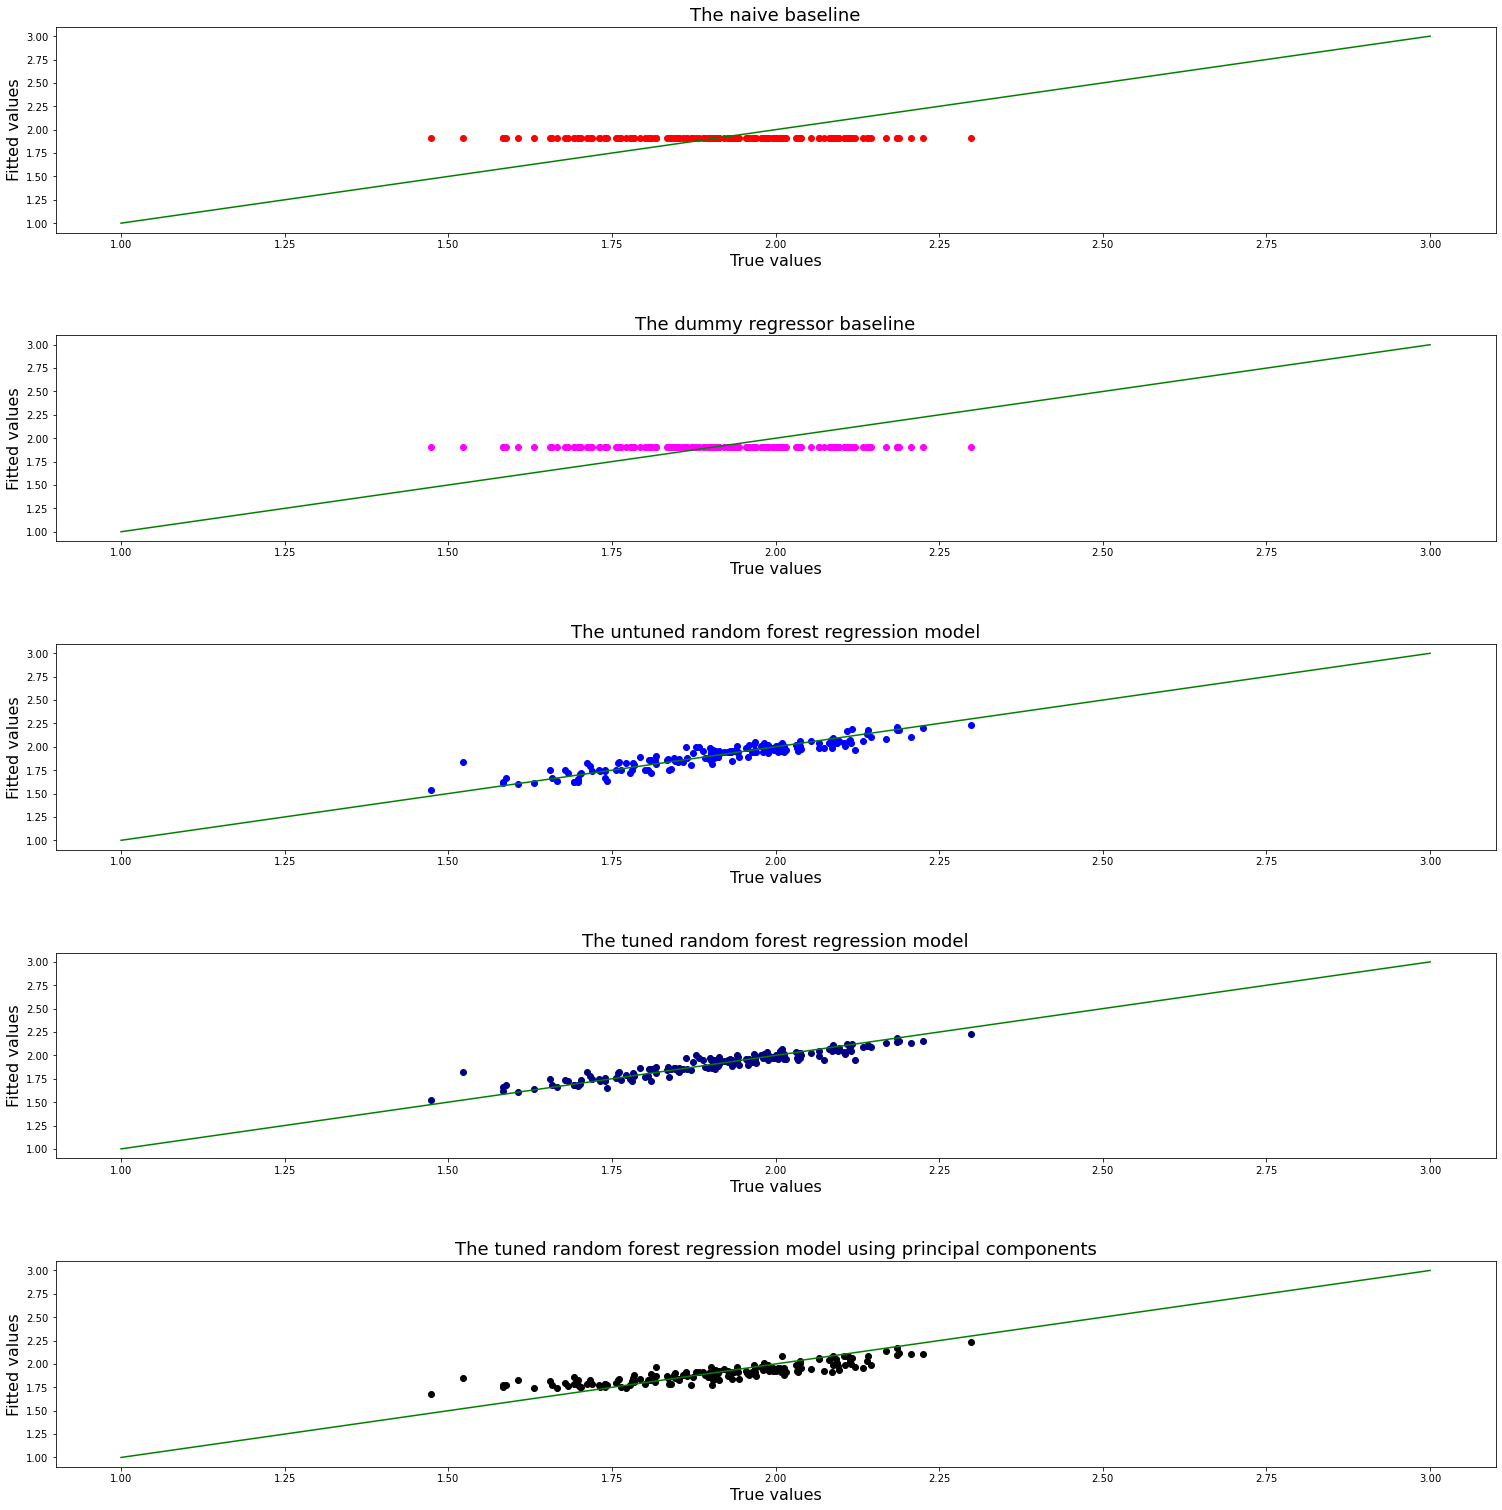

In [59]:
# Plotting model
fig = plt.figure(figsize = (20,20))
fig.subplots_adjust( left = 0, right = 1, bottom = 0, top = 1, hspace =0.5, wspace = 0.5)

ax = fig.add_subplot(5, 1, 1)
plt.scatter(y_test, y_baseline, color = 'red')
plt.plot(range(1,4), range(1,4),  color = 'green')
plt.title("The naive baseline", fontsize=18)
plt.xlabel('True values', fontsize = 16)
plt.ylabel('Fitted values', fontsize = 16)

ax = fig.add_subplot(5, 1, 2)
plt.scatter(y_test, y_predict_dummy_mean, color = 'magenta')
plt.plot(range(1,4), range(1,4),  color = 'green')
plt.title("The dummy regressor baseline", fontsize=18)
plt.xlabel('True values', fontsize = 16)
plt.ylabel('Fitted values', fontsize = 16)

ax = fig.add_subplot(5, 1, 3)
plt.scatter(y_test, preds_test_untuned_rf, color = 'blue')
plt.plot(range(1,4), range(1,4),  color = 'green')
plt.title("The untuned random forest regression model", fontsize=18)
plt.xlabel('True values', fontsize = 16)
plt.ylabel('Fitted values', fontsize = 16)

ax = fig.add_subplot(5, 1, 4)
plt.scatter(y_test, preds_test_tuned_rf, color = 'NAVY')
plt.plot(range(1,4), range(1,4),  color = 'green')
plt.title("The tuned random forest regression model", fontsize=18)
plt.xlabel('True values', fontsize = 16)
plt.ylabel('Fitted values', fontsize = 16)

ax = fig.add_subplot(5, 1, 5)
plt.scatter(y_test, pca_test_untuned_prediction, color = 'black')
plt.plot(range(1,4), range(1,4),  color = 'green')
plt.title("The tuned random forest regression model using principal components", fontsize=18)
plt.xlabel('True values', fontsize = 16)
plt.ylabel('Fitted values', fontsize = 16)